# Advanced Data Segmentation (Clustering & HMM)

This notebook explores unsupervised learning techniques to segment workout data into "Active" and "Rest" periods. We will compare **K-Means Clustering**, **Gaussian Mixture Models (GMM)**, and **Hidden Markov Models (HMM)** against the manual thresholding approach.

**Goal**: Improve segmentation robustness using probabilistic models.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from hmmlearn import hmm

# Load Data
data_path = '../data/processed/cleaned_data.csv'
df = pd.read_csv(data_path)
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)

# Calculate Magnitude
df['Acc_Magnitude'] = np.sqrt(df['AccX(g)']**2 + df['AccY(g)']**2 + df['AccZ(g)']**2)

# --- Feature Engineering ---
# We need features that distinguish 'Active' (high energy/variance) from 'Rest' (low energy/variance)

# Calculate Sampling Frequency
time_diff = (df.index[1] - df.index[0]).total_seconds()
sampling_freq = 1 / time_diff

# Define Window Size (e.g., 1 second)
window_sec = 1.0
window_size = int(window_sec * sampling_freq)

# 1. Rolling Variance
df['Feat_Variance'] = df['Acc_Magnitude'].rolling(window=window_size).var()

# 2. Rolling Mean (of Magnitude)
df['Feat_Mean'] = df['Acc_Magnitude'].rolling(window=window_size).mean()

# 3. Rolling Energy (Sum of Squares)
df['Feat_Energy'] = df['Acc_Magnitude'].rolling(window=window_size).apply(lambda x: np.sum(x**2), raw=True)

# Drop NaN values created by rolling window
df_features = df[['Feat_Variance', 'Feat_Mean', 'Feat_Energy']].dropna()

# Standardize Features
scaler = StandardScaler()
X = scaler.fit_transform(df_features)

print(f"Features shape: {X.shape}")
df_features.head()

Features shape: (1110, 3)


,Feat_Variance,Feat_Mean,Feat_Energy
time,,,
2025-12-23 15:13:38.620,0.000898,0.487838,1.910173
2025-12-23 15:13:38.169,0.000952,0.484866,1.887421
2025-12-23 15:13:38.242,0.001089,0.482295,1.868490
2025-12-23 15:13:38.332,0.001011,0.476306,1.822012
2025-12-23 15:13:38.455,0.001088,0.477621,1.832585


In [6]:
# --- Method 1: K-Means Clustering ---
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
labels_kmeans = kmeans.fit_predict(X)

# Align labels: Ensure 'Active' is 1 (Cluster with higher mean variance)
cluster_centers = kmeans.cluster_centers_
# Feature 0 is Variance. Check which cluster center has higher variance.
if cluster_centers[0, 0] > cluster_centers[1, 0]:
    # Cluster 0 is Active, Cluster 1 is Rest. No change needed if we want Active=0? No, usually Active=1.
    # Let's map: Higher Variance -> 1, Lower -> 0
    labels_kmeans = np.where(labels_kmeans == 0, 1, 0)
else:
    # Cluster 1 is Active (Higher Variance). Labels are already 0 and 1.
    # Just to be sure, if Cluster 1 is Active, labels are correct (0=Rest, 1=Active)
    pass

df_features['Label_KMeans'] = labels_kmeans

# --- Method 2: Gaussian Mixture Models (GMM) ---
gmm = GaussianMixture(n_components=2, random_state=42)
gmm.fit(X)
labels_gmm = gmm.predict(X)

# Align labels for GMM
# Check means of the components. GMM means are in gmm.means_
if gmm.means_[0, 0] > gmm.means_[1, 0]:
    labels_gmm = np.where(labels_gmm == 0, 1, 0)

df_features['Label_GMM'] = labels_gmm

# --- Method 3: Hidden Markov Model (HMM) ---
# HMM is great for time-series because it models transitions (Rest -> Active -> Rest)
# GaussianHMM assumes features are Gaussian distributed
model_hmm = hmm.GaussianHMM(n_components=2, covariance_type="diag", n_iter=100, random_state=42)
model_hmm.fit(X)
labels_hmm = model_hmm.predict(X)

# Align labels for HMM
if model_hmm.means_[0, 0] > model_hmm.means_[1, 0]:
    labels_hmm = np.where(labels_hmm == 0, 1, 0)
    
df_features['Label_HMM'] = labels_hmm
print("HMM trained successfully.")

HMM trained successfully.


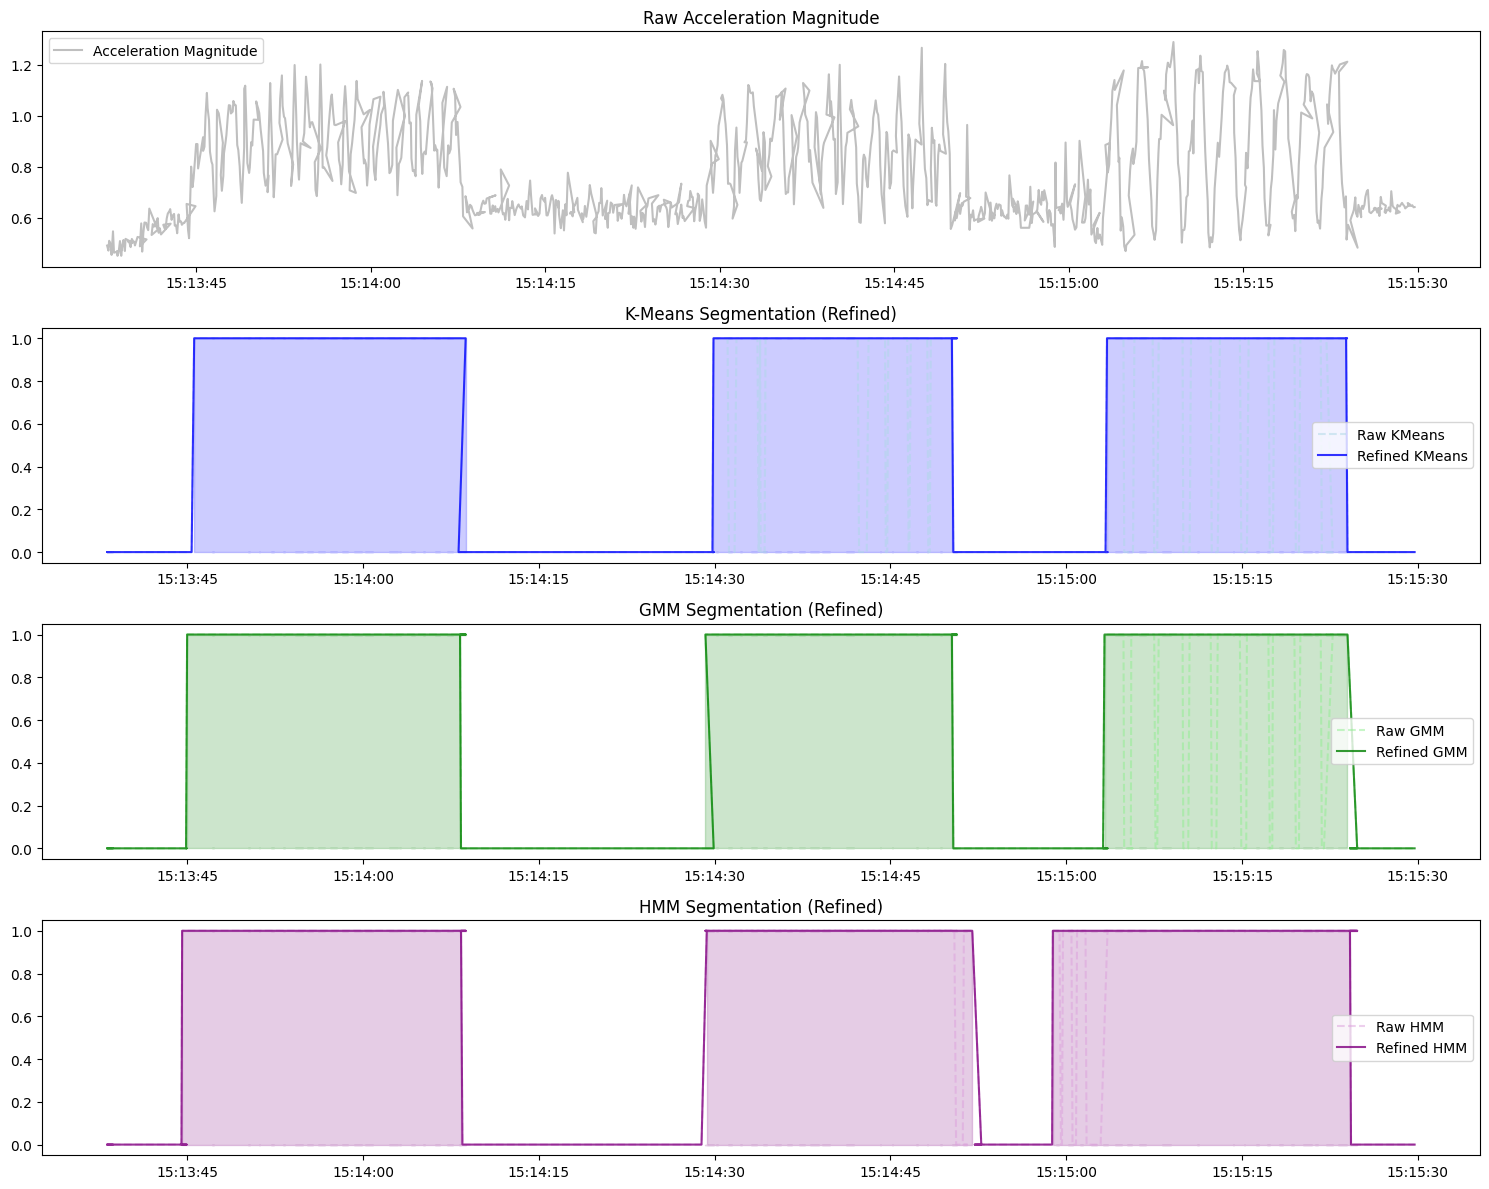

Advanced segmentation results saved.


In [7]:
# --- Post-Processing: Refine Labels ---

def refine_activity_labels(series, min_duration_sec, min_gap_sec, freq):
    """
    Refines binary activity labels by:
    1. Merging activities separated by short gaps (min_gap_sec).
    2. Removing activities shorter than a minimum duration (min_duration_sec).
    """
    # Ensure boolean for logic
    labels = series.copy().astype(bool) 
    
    # Convert seconds to samples
    min_gap_samples = int(min_gap_sec * freq)
    min_duration_samples = int(min_duration_sec * freq)
    
    # 1. Merge small gaps (Fill short 'False' periods with 'True')
    # Identify continuous blocks
    changes = labels.ne(labels.shift()).cumsum()
    counts = labels.groupby(changes).transform('count')
    
    # If label is False (Rest) and duration < min_gap, switch to True (Active)
    mask_gaps = (~labels) & (counts < min_gap_samples)
    labels[mask_gaps] = True
    
    # 2. Remove short activities (Fill short 'True' periods with 'False')
    # Re-calculate blocks after merging
    changes = labels.ne(labels.shift()).cumsum()
    counts = labels.groupby(changes).transform('count')
    
    # If label is True (Active) and duration < min_duration, switch to False (Rest)
    mask_short = (labels) & (counts < min_duration_samples)
    labels[mask_short] = False
    
    return labels.astype(int)

# Apply refinement to all methods
# Using the same parameters as the manual method: 3.0s min duration, 2.0s min gap
df_features['Label_KMeans_Refined'] = refine_activity_labels(df_features['Label_KMeans'], 3.0, 2.0, sampling_freq)
df_features['Label_GMM_Refined'] = refine_activity_labels(df_features['Label_GMM'], 3.0, 2.0, sampling_freq)
df_features['Label_HMM_Refined'] = refine_activity_labels(df_features['Label_HMM'], 3.0, 2.0, sampling_freq)

# --- Visualization & Comparison ---

plt.figure(figsize=(15, 12))

# Plot 1: Raw Acceleration
plt.subplot(4, 1, 1)
plt.plot(df.index, df['Acc_Magnitude'], label='Acceleration Magnitude', color='gray', alpha=0.5)
plt.title('Raw Acceleration Magnitude')
plt.legend()

# Plot 2: K-Means Segmentation (Refined)
plt.subplot(4, 1, 2)
plt.plot(df_features.index, df_features['Label_KMeans'], label='Raw KMeans', color='lightblue', alpha=0.5, linestyle='--')
plt.plot(df_features.index, df_features['Label_KMeans_Refined'], label='Refined KMeans', color='blue', alpha=0.8)
plt.fill_between(df_features.index, 0, 1, where=df_features['Label_KMeans_Refined'], color='blue', alpha=0.2)
plt.title('K-Means Segmentation (Refined)')
plt.legend()

# Plot 3: GMM Segmentation (Refined)
plt.subplot(4, 1, 3)
plt.plot(df_features.index, df_features['Label_GMM'], label='Raw GMM', color='lightgreen', alpha=0.5, linestyle='--')
plt.plot(df_features.index, df_features['Label_GMM_Refined'], label='Refined GMM', color='green', alpha=0.8)
plt.fill_between(df_features.index, 0, 1, where=df_features['Label_GMM_Refined'], color='green', alpha=0.2)
plt.title('GMM Segmentation (Refined)')
plt.legend()

# Plot 4: HMM Segmentation (Refined)
plt.subplot(4, 1, 4)
plt.plot(df_features.index, df_features['Label_HMM'], label='Raw HMM', color='plum', alpha=0.5, linestyle='--')
plt.plot(df_features.index, df_features['Label_HMM_Refined'], label='Refined HMM', color='purple', alpha=0.8)
plt.fill_between(df_features.index, 0, 1, where=df_features['Label_HMM_Refined'], color='purple', alpha=0.2)
plt.title('HMM Segmentation (Refined)')
plt.legend()

plt.tight_layout()
plt.show()

# Save Results
df_features.to_csv('../data/processed/segmented_data_advanced.csv')
print("Advanced segmentation results saved.")